In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# matplotlib 한글 폰트 적용
# 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치 후 런타임 다시시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

In [4]:
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'NanumBarunGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 로딩

In [5]:
(train_image, train_label), (test_image, test_label) = keras.datasets.cifar10.load_data()

In [6]:
train_image.shape, test_image.shape, train_label.shape, test_label.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [7]:
np.unique(train_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
class_names = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭'])

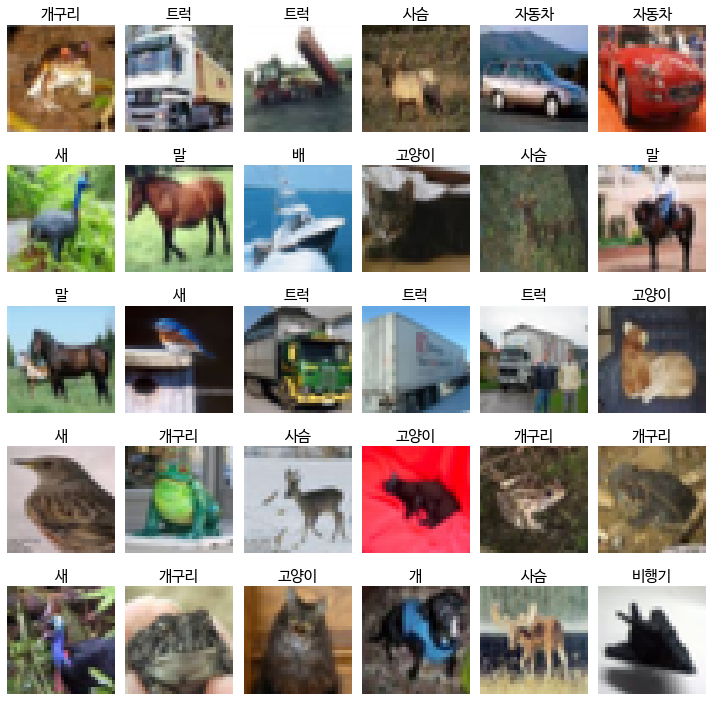

In [9]:
# 이미지 확인
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(train_image[i])
    plt.title(class_names[train_label[i,0]], fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()    

# 데이터 전처리
- X: 0 ~ 1 scaling
- y: onehot encoding

In [10]:
X_train = (train_image/255.0).astype(np.float32)
X_test = (test_image/255.0).astype(np.float32)

y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

np.min(X_train), np.max(X_train), y_train.shape, y_test.shape

(0.0, 1.0, (50000, 10), (10000, 10))

# 하이퍼파라미터, 변수 정의

In [11]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS  = 100

N_TRAIN = X_train.shape[0]
N_TEST = X_test.shape[0]
IMAGE_SIZE = 32

# Dataset 생성
- train/test set

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

# 모델 생성 및 컴파일
- CNN 모델을 이용해 10개의 class를 분류하는 모델을 구현

In [13]:
def create_cifar10_model():
    model = keras.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))
    
    model.add(layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=10, activation='softmax')) 

    return model

In [14]:
model = create_cifar10_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                    

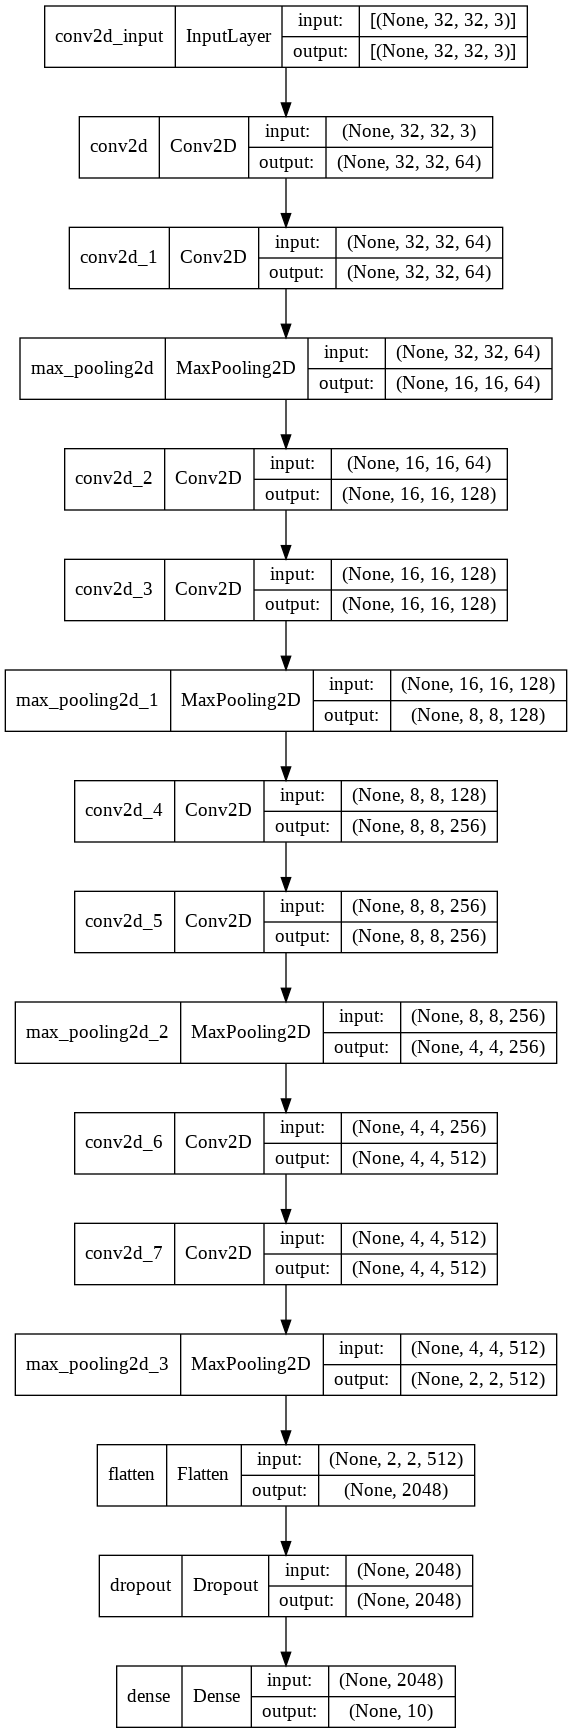

In [16]:
keras.utils.plot_model(model, show_shapes=True)

# 학습 및 평가
- callback을 이용해 early stopping, 가장 성능 좋았을때 모델 저장 하세요.
    - 모델은 자신의 google drive에 저장하세요.
- 저장됬던 모델을 loading한 뒤 그 모델도 평가해보세요.

In [20]:
import os
base_dir = '/content/drive/MyDrive'
save_dir = os.path.join(base_dir, "saved_models", "cifa10_model")
print(save_dir)

/content/drive/MyDrive/saved_models/cifa10_model


In [21]:
# callback 생성
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_dir, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=1)

In [22]:
hist = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset, 
                 callbacks=[es_callback, mc_callback])

Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.5561
Epoch 00001: val_loss improved from inf to 1.09651, saving model to /content/drive/MyDrive/saved_models/cifa10_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/cifa10_model/assets
500/500 [==============================] - 37s 73ms/step - loss: 1.2290 - accuracy: 0.5561 - val_loss: 1.0965 - val_accuracy: 0.6136
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.9466 - accuracy: 0.6644
Epoch 00002: val_loss improved from 1.09651 to 0.88728, saving model to /content/drive/MyDrive/saved_models/cifa10_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/cifa10_model/assets
500/500 [==============================] - 37s 73ms/step - loss: 0.9466 - accuracy: 0.6644 - val_loss: 0.8873 - val_accuracy: 0.6868
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.7359
Epoch 00003: val_loss i

### loss/accuracy 시각화 함수

In [23]:
# loss 그래프
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
# accuracy 그래프
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()    

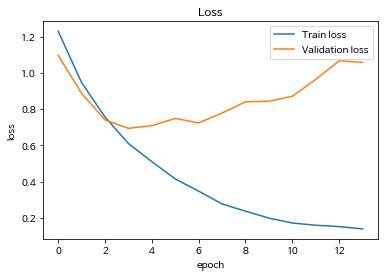

In [24]:
plot_loss(hist)

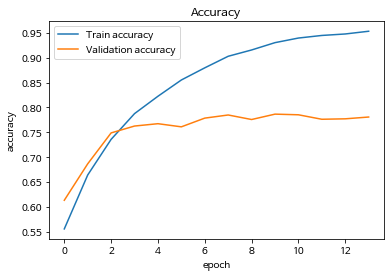

In [25]:
plot_accuracy(hist)

### 평가

In [27]:
loss, accuracy = model.evaluate(test_dataset)

100/100 [==============================] - 2s 22ms/step - loss: 1.0577 - accuracy: 0.7808


In [28]:
print(loss, accuracy)

1.0576519966125488 0.7807999849319458


### 저장된 모델 로딩 및 평가

In [30]:
load_model = keras.models.load_model(save_dir)

In [31]:
loss2, accuracy2 = load_model.evaluate(test_dataset)

100/100 [==============================] - 3s 22ms/step - loss: 0.6946 - accuracy: 0.7627


In [32]:
loss2, accuracy2

(0.6945804357528687, 0.7627000212669373)